In [1]:
# imports
import re

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from datetime import datetime
import theano
import theano.tensor as tt
import pickle as pkl

from scipy import stats
import os

import scipy as sp
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.9.3


In [3]:
with open("model", "rb") as f:
    model = pkl.load(f)
with open("trace", "rb") as f:
    trace = pkl.load(f)
    
with open("predictions", "rb") as f:
    pred = pkl.load(f)

C:\Users\lkrie\AppData\Roaming\Python\Python37\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\lkrie\AppData\Roaming\Python\Python37\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\lkrie\AppData\Roaming\Python\Python37\site-packages\arviz\plots\traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (27), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C50DA77FC8>,
      dtype=object)

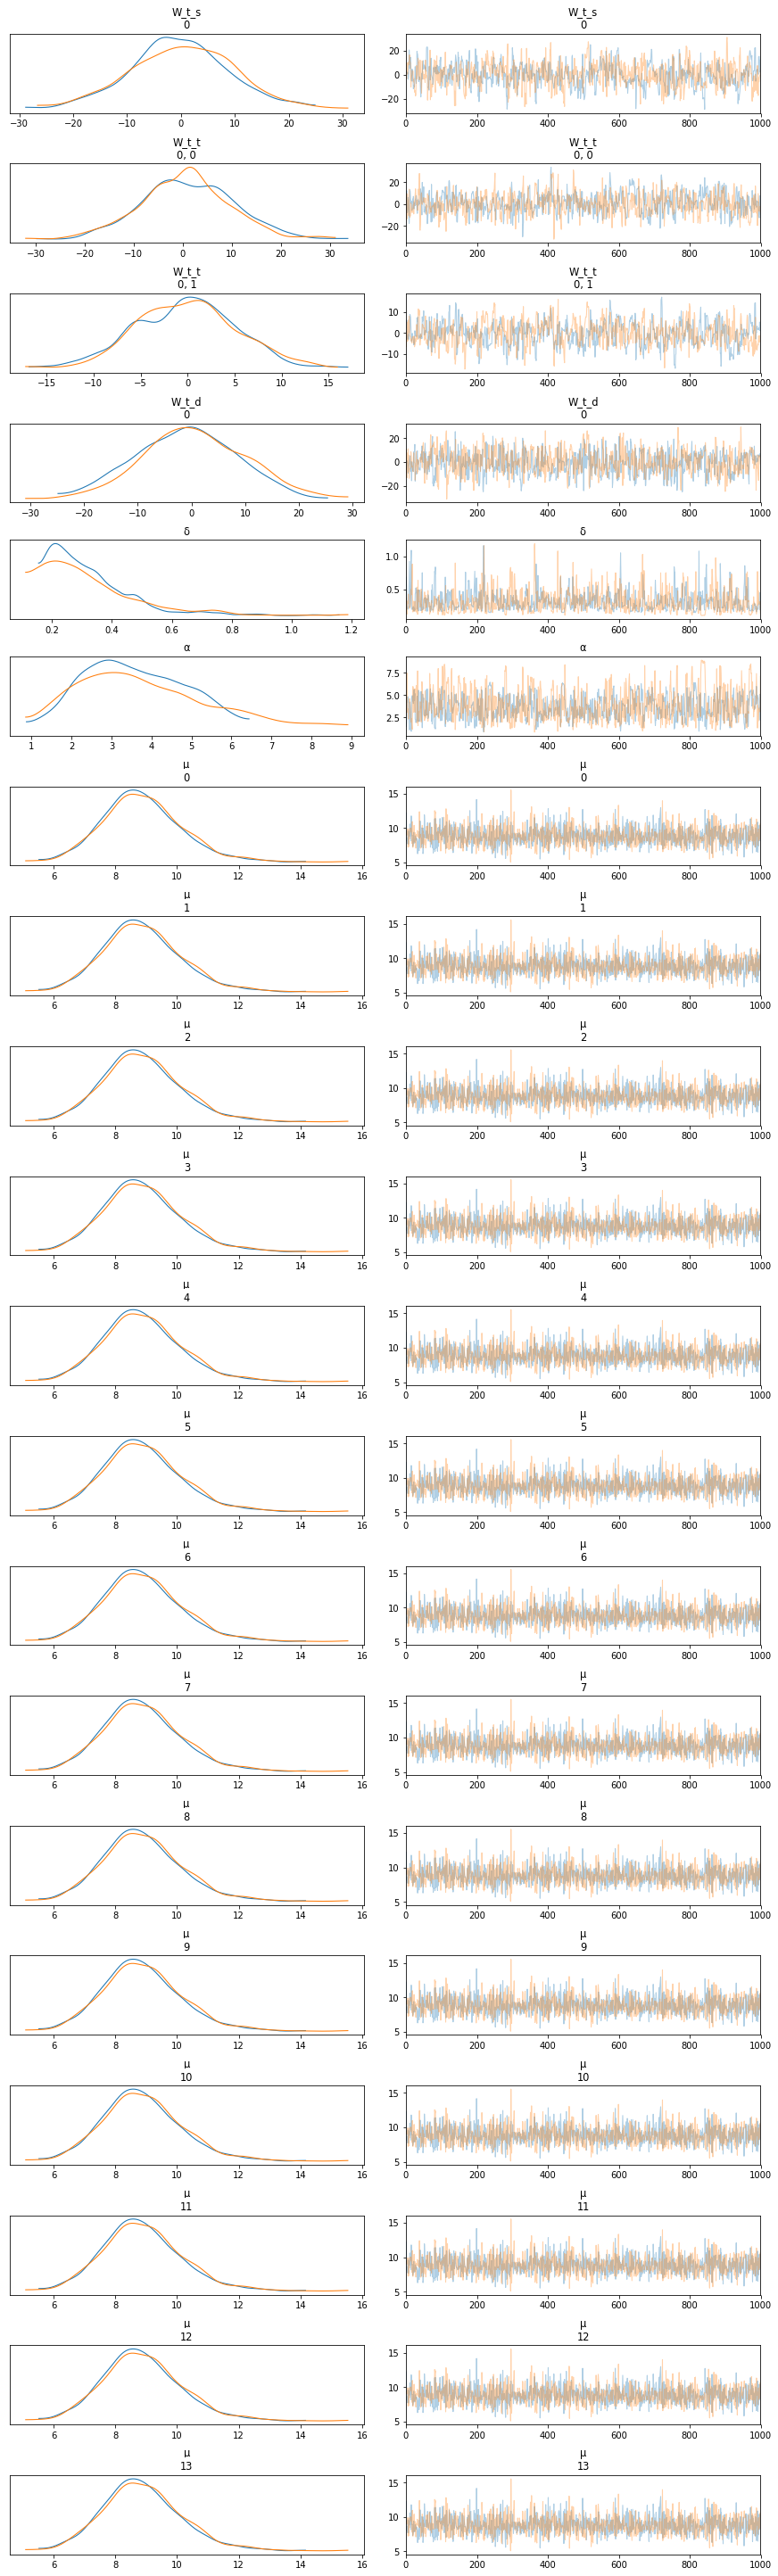

In [4]:
az.plot_trace(trace)

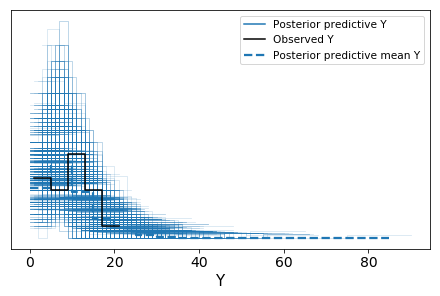

In [6]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace    )
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model));